In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import time
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
# Load dataset
url =  r"C:\Users\23adsb61\Downloads\bank-full.csv"
df = pd.read_csv(url, sep=';')
print(f"Dataset Shape: {df.shape}")
print(f"\nTarget Distribution:\n{df['y'].value_counts()}")

Dataset Shape: (45211, 17)

Target Distribution:
y
no     39922
yes     5289
Name: count, dtype: int64


In [3]:
# Preprocess data
data = df.copy()
data = data.replace('unknown', np.nan)

X = data.drop('y', axis=1)
y = data['y'].map({'yes': 1, 'no': 0})

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in categorical_cols:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].mode()[0], inplace=True)

for col in numerical_cols:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print(f"Feature dimensions: {X.shape}")

Feature dimensions: (45211, 47)


In [4]:
# Train-Validation-Test Split (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

print(f"Training: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

Training: 31647 (70.0%)
Validation: 6782 (15.0%)
Test: 6782 (15.0%)


In [5]:
# Define model architecture
def create_model(input_dim, seed=RANDOM_SEED):
    tf.random.set_seed(seed)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])
    return model

input_dim = X_train_scaled.shape[1]
create_model(input_dim).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training function
def train_model(optimizer, name, batch_size=32, max_epochs=200, patience=5):
    model = create_model(input_dim)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    
    start_time = time.time()
    history = model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=max_epochs,
                       validation_data=(X_val_scaled, y_val), callbacks=[early_stop], verbose=0)
    training_time = time.time() - start_time
    
    print(f"{name}: {len(history.history['loss'])} epochs, {training_time:.2f}s")
    return model, history, training_time

In [9]:
# Train all optimizers
LEARNING_RATE = 0.001
results = {}

print("Training Optimizers...\n")

# 1. Batch GD
model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE), "Batch GD", batch_size=len(X_train_scaled))
results['Batch GD'] = {'model': model, 'history': history, 'time': time_taken}

# 2. SGD
model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE), "SGD", batch_size=1)
results['SGD'] = {'model': model, 'history': history, 'time': time_taken}

# 3. Mini-Batch GD
model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE), "Mini-Batch GD", batch_size=32)
results['Mini-Batch GD'] = {'model': model, 'history': history, 'time': time_taken}

# 4. Momentum
model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9), "Momentum", batch_size=32)
results['Momentum'] = {'model': model, 'history': history, 'time': time_taken}

# 5. Nesterov
model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True), "Nesterov", batch_size=32)
results['Nesterov'] = {'model': model, 'history': history, 'time': time_taken}

Training Optimizers...

Restoring model weights from the end of the best epoch: 200.
Batch GD: 200 epochs, 28.21s
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
SGD: 30 epochs, 1704.58s
Restoring model weights from the end of the best epoch: 200.
Mini-Batch GD: 200 epochs, 395.13s
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 73.
Momentum: 78 epochs, 137.63s
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 95.
Nesterov: 100 epochs, 191.27s


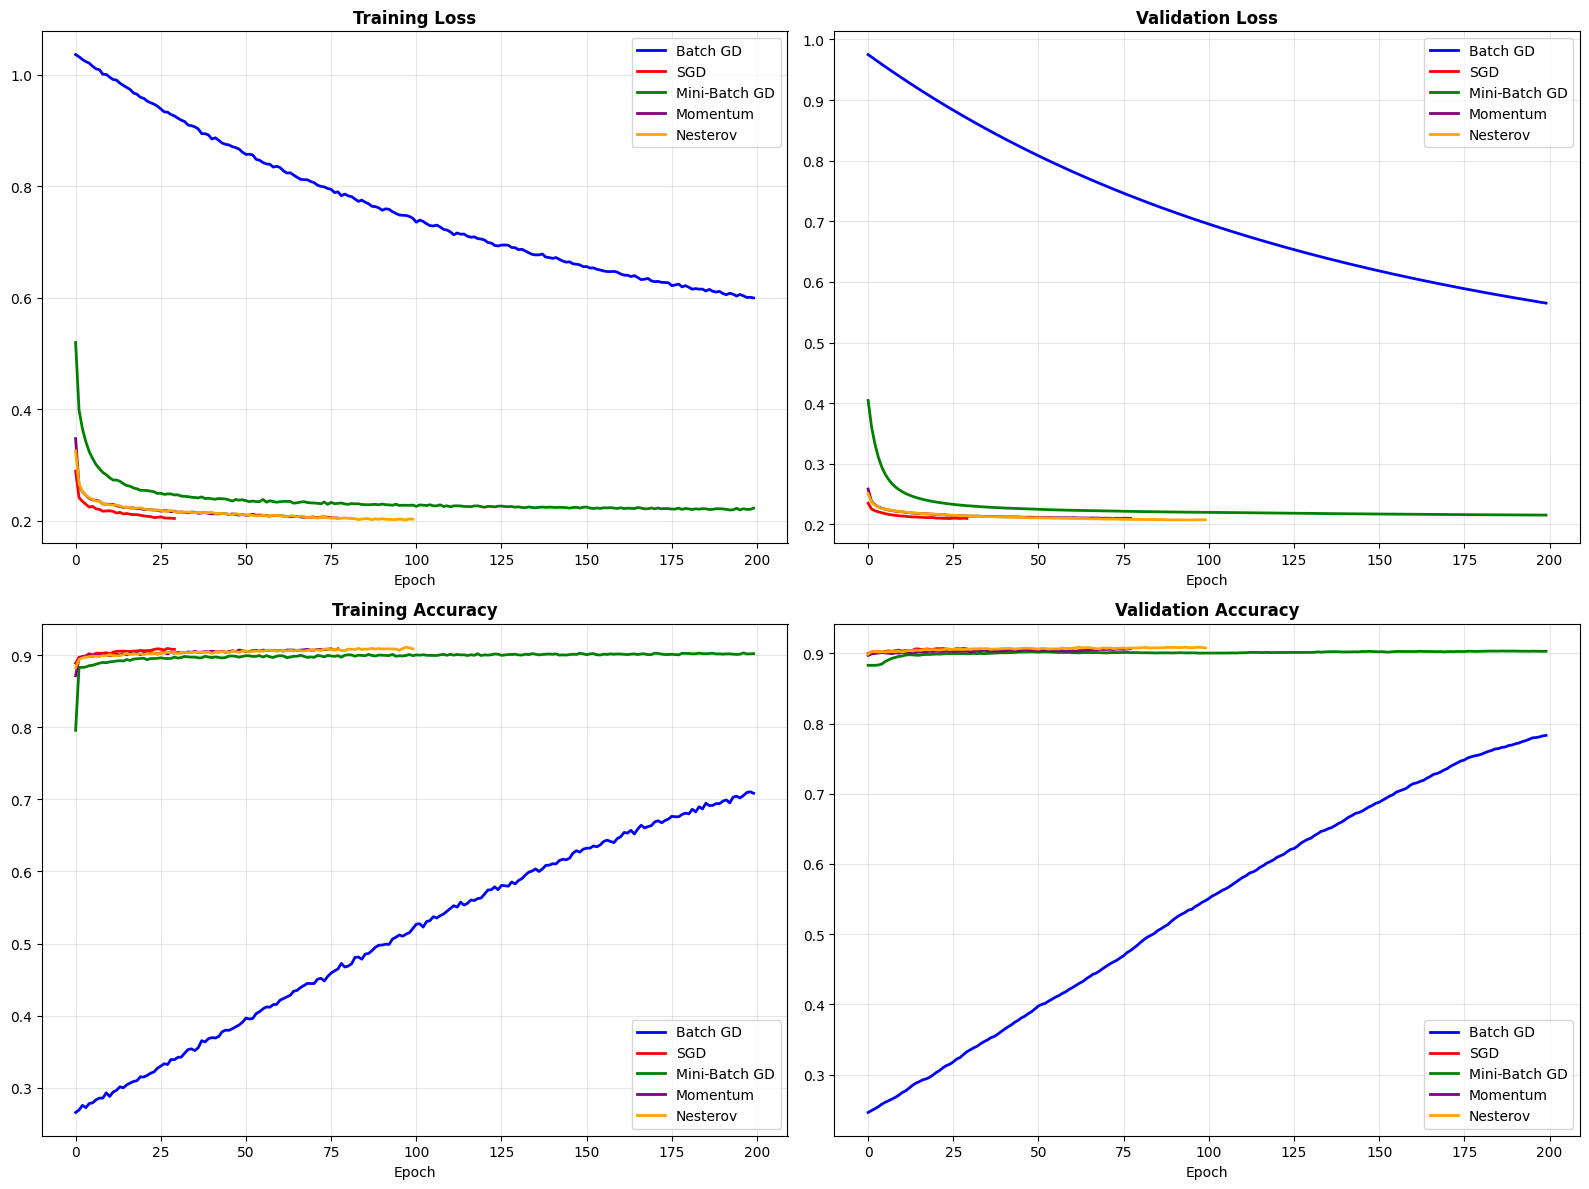

In [10]:
# Comparative plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = {'Batch GD': 'blue', 'SGD': 'red', 'Mini-Batch GD': 'green', 'Momentum': 'purple', 'Nesterov': 'orange'}

for name, result in results.items():
    history = result['history']
    axes[0, 0].plot(history.history['loss'], label=name, color=colors[name], linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label=name, color=colors[name], linewidth=2)
    axes[1, 0].plot(history.history['accuracy'], label=name, color=colors[name], linewidth=2)
    axes[1, 1].plot(history.history['val_accuracy'], label=name, color=colors[name], linewidth=2)

axes[0, 0].set_title('Training Loss', fontweight='bold'); axes[0, 0].set_xlabel('Epoch'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].set_title('Validation Loss', fontweight='bold'); axes[0, 1].set_xlabel('Epoch'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].set_title('Training Accuracy', fontweight='bold'); axes[1, 0].set_xlabel('Epoch'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].set_title('Validation Accuracy', fontweight='bold'); axes[1, 1].set_xlabel('Epoch'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Performance summary
summary_data = []
for name, result in results.items():
    history = result['history']
    summary_data.append({
        'Optimizer': name,
        'Epochs': len(history.history['loss']),
        'Time (s)': f"{result['time']:.2f}",
        'Train Loss': f"{history.history['loss'][-1]:.4f}",
        'Val Loss': f"{history.history['val_loss'][-1]:.4f}",
        'Train Acc': f"{history.history['accuracy'][-1]:.4f}",
        'Val Acc': f"{history.history['val_accuracy'][-1]:.4f}"
    })

pd.DataFrame(summary_data)

,Optimizer,Epochs,Time (s),Train Loss,Val Loss,Train Acc,Val Acc
0,Batch GD,200,28.21,0.6001,0.5650,0.7084,0.7831
1,SGD,30,1704.58,0.2045,0.2097,0.9082,0.9062
2,Mini-Batch GD,200,395.13,0.2230,0.2153,0.9021,0.9030
3,Momentum,78,137.63,0.2051,0.2100,0.9088,0.9065
4,Nesterov,100,191.27,0.2031,0.2075,0.9089,0.9077


Batch Size Analysis...

Restoring model weights from the end of the best epoch: 200.
BS=16: 200 epochs, 792.21s
Restoring model weights from the end of the best epoch: 200.
BS=32: 200 epochs, 408.71s
Restoring model weights from the end of the best epoch: 200.
BS=64: 200 epochs, 231.30s
Restoring model weights from the end of the best epoch: 200.
BS=128: 200 epochs, 123.48s


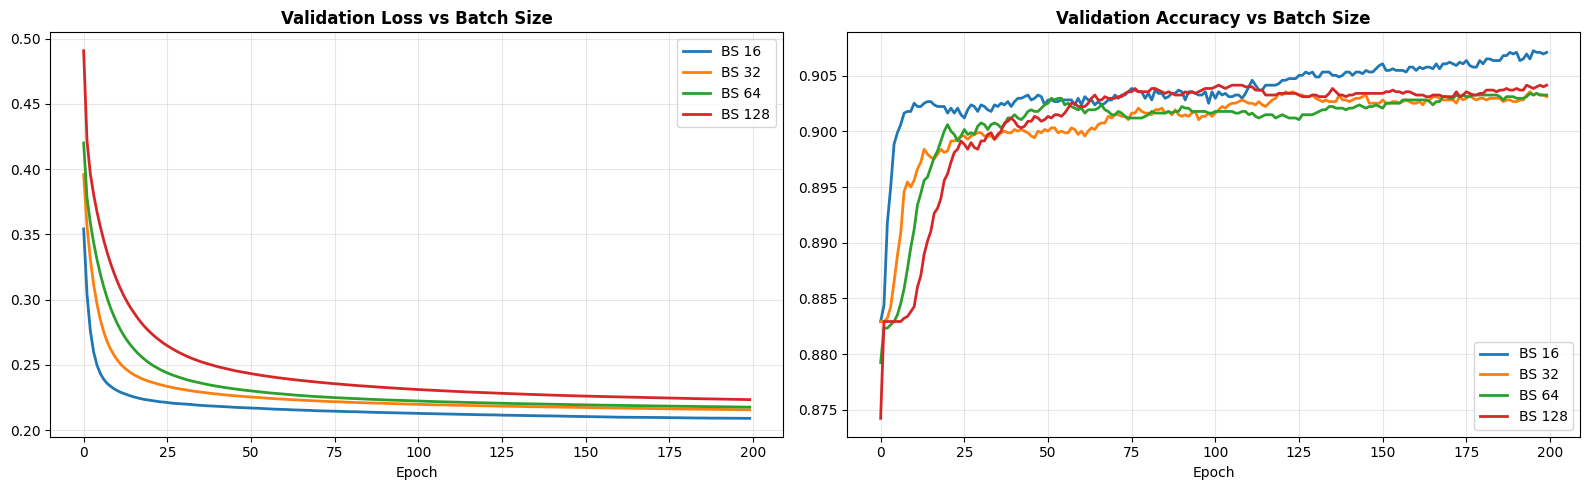

In [12]:
# Batch size analysis
print("Batch Size Analysis...\n")
batch_sizes = [16, 32, 64, 128]
batch_results = {}

for bs in batch_sizes:
    model, history, time_taken = train_model(optimizers.SGD(learning_rate=LEARNING_RATE), f"BS={bs}", batch_size=bs)
    batch_results[bs] = {'history': history, 'time': time_taken}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for bs, result in batch_results.items():
    axes[0].plot(result['history'].history['val_loss'], label=f'BS {bs}', linewidth=2)
    axes[1].plot(result['history'].history['val_accuracy'], label=f'BS {bs}', linewidth=2)

axes[0].set_title('Validation Loss vs Batch Size', fontweight='bold'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_title('Validation Accuracy vs Batch Size', fontweight='bold'); axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Learning Rate Sensitivity...

Restoring model weights from the end of the best epoch: 200.
LR=0.0001: 200 epochs, 437.80s
Restoring model weights from the end of the best epoch: 200.
LR=0.001: 200 epochs, 508.20s
Epoch 103: early stopping
Restoring model weights from the end of the best epoch: 98.
LR=0.01: 103 epochs, 265.59s
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.
LR=0.1: 30 epochs, 77.60s


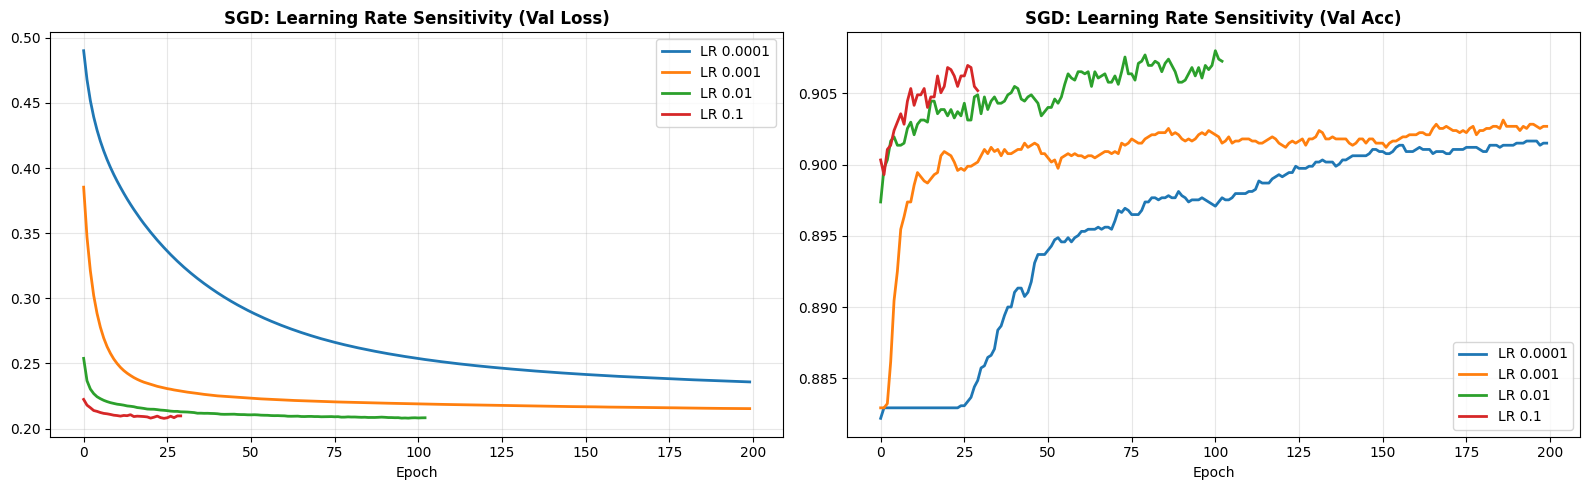

In [13]:
# Learning rate sensitivity (SGD)
print("Learning Rate Sensitivity...\n")
learning_rates = [0.0001, 0.001, 0.01, 0.1]
lr_results = {}

for lr in learning_rates:
    model, history, time_taken = train_model(optimizers.SGD(learning_rate=lr), f"LR={lr}", batch_size=32)
    lr_results[lr] = {'history': history}

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for lr, result in lr_results.items():
    axes[0].plot(result['history'].history['val_loss'], label=f'LR {lr}', linewidth=2)
    axes[1].plot(result['history'].history['val_accuracy'], label=f'LR {lr}', linewidth=2)

axes[0].set_title('SGD: Learning Rate Sensitivity (Val Loss)', fontweight='bold'); axes[0].set_xlabel('Epoch'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_title('SGD: Learning Rate Sensitivity (Val Acc)', fontweight='bold'); axes[1].set_xlabel('Epoch'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Momentum Sensitivity...

Epoch 197: early stopping
Restoring model weights from the end of the best epoch: 192.
Mom=0.5: 197 epochs, 503.12s
Restoring model weights from the end of the best epoch: 200.
Nes=0.5: 200 epochs, 511.50s
Restoring model weights from the end of the best epoch: 196.
Mom=0.7: 200 epochs, 490.79s
Restoring model weights from the end of the best epoch: 200.
Nes=0.7: 200 epochs, 505.67s
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.
Mom=0.9: 66 epochs, 169.94s
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 75.
Nes=0.9: 80 epochs, 198.95s
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.
Mom=0.95: 38 epochs, 95.02s
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 62.
Nes=0.95: 67 epochs, 170.24s


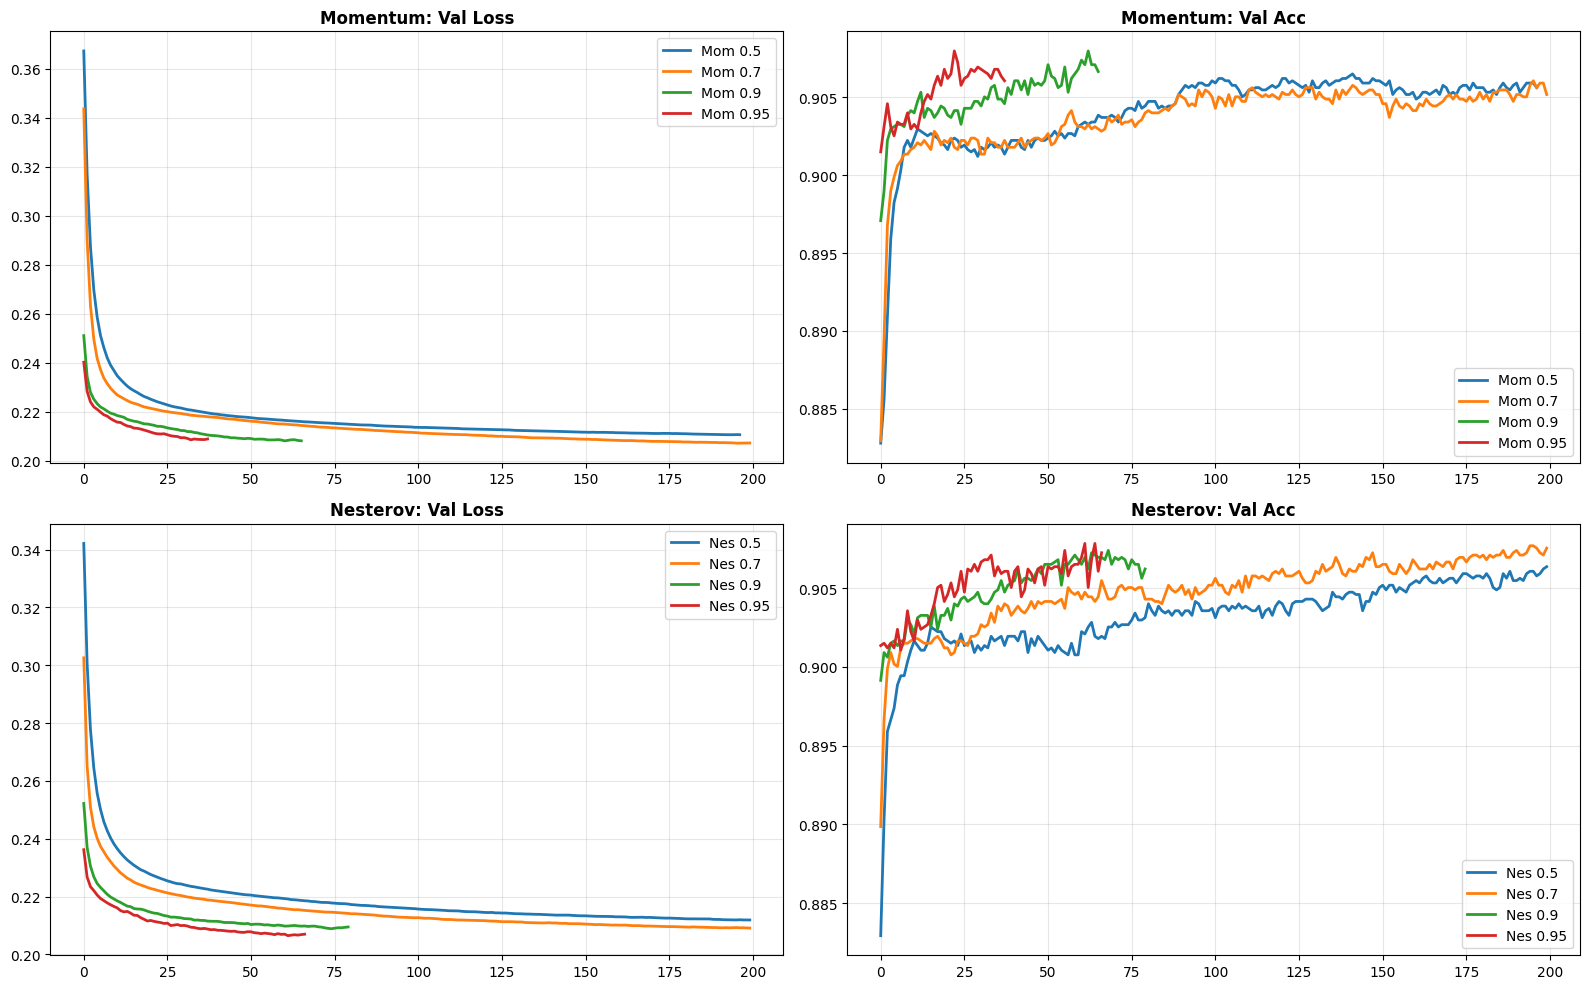

In [14]:
# Momentum sensitivity
print("Momentum Sensitivity...\n")
momentum_values = [0.5, 0.7, 0.9, 0.95]
momentum_results = {}
nesterov_results = {}

for m in momentum_values:
    model, history, _ = train_model(optimizers.SGD(learning_rate=LEARNING_RATE, momentum=m), f"Mom={m}", batch_size=32)
    momentum_results[m] = {'history': history}
    
    model, history, _ = train_model(optimizers.SGD(learning_rate=LEARNING_RATE, momentum=m, nesterov=True), f"Nes={m}", batch_size=32)
    nesterov_results[m] = {'history': history}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for m, result in momentum_results.items():
    axes[0, 0].plot(result['history'].history['val_loss'], label=f'Mom {m}', linewidth=2)
    axes[0, 1].plot(result['history'].history['val_accuracy'], label=f'Mom {m}', linewidth=2)
for m, result in nesterov_results.items():
    axes[1, 0].plot(result['history'].history['val_loss'], label=f'Nes {m}', linewidth=2)
    axes[1, 1].plot(result['history'].history['val_accuracy'], label=f'Nes {m}', linewidth=2)

axes[0, 0].set_title('Momentum: Val Loss', fontweight='bold'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].set_title('Momentum: Val Acc', fontweight='bold'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].set_title('Nesterov: Val Loss', fontweight='bold'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].set_title('Nesterov: Val Acc', fontweight='bold'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Best Optimizer: Nesterov

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
Accuracy:  0.9034
Precision: 0.6268
Recall:    0.4300
F1-Score:  0.5101


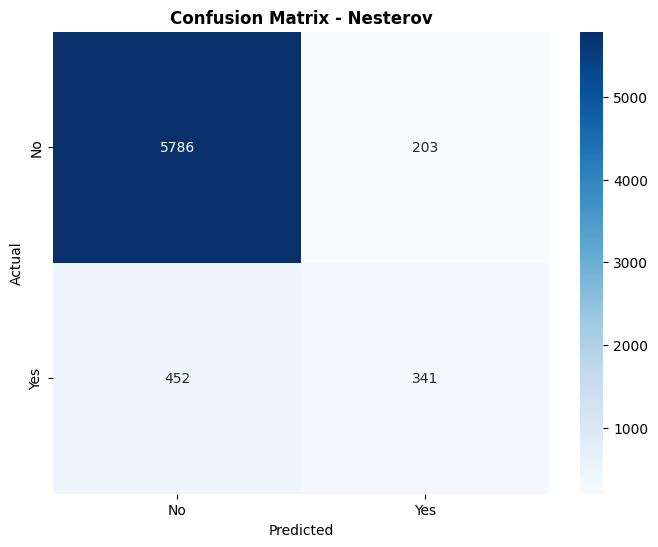


Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.97      0.95      5989
         Yes       0.63      0.43      0.51       793

    accuracy                           0.90      6782
   macro avg       0.78      0.70      0.73      6782
weighted avg       0.89      0.90      0.90      6782



In [15]:
# Best model evaluation
best_name = max(results.items(), key=lambda x: x[1]['history'].history['val_accuracy'][-1])[0]
best_model = results[best_name]['model']

print(f"Best Optimizer: {best_name}\n")

y_pred = (best_model.predict(X_test_scaled) > 0.5).astype(int).flatten()

print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}', fontweight='bold')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

In [16]:
# Comparative analysis
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)

print("\n1. Convergence Speed:")
for name, result in results.items():
    epochs = len(result['history'].history['loss'])
    print(f"{name:15s}: {epochs:3d} epochs, {result['time']:6.2f}s")

print("\n2. Oscillation (Validation Loss Std Dev):")
for name, result in results.items():
    std = np.std(result['history'].history['val_loss'])
    print(f"{name:15s}: {std:.6f}")

print("\n3. Stability (Last 5 Epochs):")
for name, result in results.items():
    std = np.std(result['history'].history['val_loss'][-5:])
    print(f"{name:15s}: {std:.6f}")

print("\n4. Generalization (Train-Val Gap):")
for name, result in results.items():
    gap = result['history'].history['accuracy'][-1] - result['history'].history['val_accuracy'][-1]
    print(f"{name:15s}: {gap:.4f}")

print("\n" + "="*80)


COMPARATIVE ANALYSIS

1. Convergence Speed:
Batch GD       : 200 epochs,  28.21s
SGD            :  30 epochs, 1704.58s
Mini-Batch GD  : 200 epochs, 395.13s
Momentum       :  78 epochs, 137.63s
Nesterov       : 100 epochs, 191.27s

2. Oscillation (Validation Loss Std Dev):
Batch GD       : 0.116401
SGD            : 0.005572
Mini-Batch GD  : 0.021916
Momentum       : 0.007302
Nesterov       : 0.006827

3. Stability (Last 5 Epochs):
Batch GD       : 0.001312
SGD            : 0.000236
Mini-Batch GD  : 0.000054
Momentum       : 0.000099
Nesterov       : 0.000114

4. Generalization (Train-Val Gap):
Batch GD       : -0.0747
SGD            : 0.0020
Mini-Batch GD  : -0.0008
Momentum       : 0.0023
Nesterov       : 0.0012

